In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import matplotlib.pyplot as plt
import itertools

In [2]:
# Import transformers package from huggingface
%%capture
!pip install transformers

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel

In [4]:
# Import Bio_ClinicalBERT model from huggingface
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_cased')
model = AutoModel.from_pretrained('allenai/scibert_scivocab_cased')

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/217k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("drive/My Drive/CMU/10-701/outputacm.txt") as f:
    lines = f.read()

In [ ]:
lines = lines.split('\n\n')

In [ ]:
df = pd.DataFrame(columns=['Title', 'Authors', 'Year', 'Venue', 'ID', 'Citations', 'Abstract'])

l = []
for index,line in enumerate(lines):

  print(f"Line Number {index} out of {len(lines)}")
  split = line.split('\n')

  d = {}

  for a in split:
    if (a[1] == '*'):
      d['Title'] = a[2:]
    if (a[1] == '@'):
      d['Authors'] = a[2:]
    if (a[1] == 't'):
      d['Year'] = a[2:]
    if (a[1] == 'c'):
      d['Venue'] = a[2:]
    if (a[1] == 'index'):
      d['ID'] = a[2:]
    if (a[1] =='%'):
      if("Citations" not in d.keys()):
        d['Citations'] = a[2:]
      else:
        d['Citations'] += (',' + a[2:])
    if (a[1] == '!'):
      d['Abstract'] = a[2:]

  l.append(d)

In [ ]:
df = pd.DataFrame(l)

In [ ]:
df.to_csv('drive/My Drive/CMU/10-701/dataset_corrected.csv')


### Input data from existing CSV


In [8]:
## Read data in
df = pd.read_csv('drive/My Drive/CMU/10-701/dataset_corrected.csv')

In [9]:
train_df = df.loc[:int(0.90*df.shape[0]),:]
test_df = df.loc[int(0.90*df.shape[0])+1:,:]

In [10]:
# Create citation graph
train_citations_graph = train_df['Citations'].dropna().to_dict()
test_citations_graph = test_df['Citations'].dropna().to_dict()

In [11]:
len_train = len(train_df)
len_test = len(test_df)

In [ ]:
len_train

In [ ]:
# "explode" graph into tuples of x cites y
citations = [(key, int(value)) for key, values in Citations_Graph.items() for value in values.split(',')]

In [12]:
train_citations = [(key, int(value)) for key, values in train_citations_graph.items() for value in values.split(',') if int(value) < len_train]

In [13]:
test_citations = [(key, int(value)) for key, values in test_citations_graph.items() for value in values.split(',') if int(value) > len_train]

In [ ]:
## OLD CODE

# train_citations = citations[:int(0.90*len(citations))]
# test_citations = citations[int(0.90*len(citations))+1:]

In [14]:
## Citations Graph : x cites y
import random

class Citations(Dataset):

  def __init__(self,citations,df):
    super().__init__()
    
    self.citations = citations
    self.length = df.shape[0]
    self.data = df

  def __len__(self):

    return len(self.citations)

  def __getitem__(self,index):

    X = []
    X.append(self.data.loc[self.citations[index][0],:].values)
    X.append(self.data.loc[self.citations[index][0],:].values)
   

    Y = []
    Y.append(self.data.loc[self.citations[index][1],:].values)
    Y.append(self.data.loc[random.randint(0,self.length-1),:].values)


    labels = [1,0]
  
    return X,Y,labels

In [15]:
train_dataset = Citations(train_citations,df)
test_dataset = Citations(test_citations,df)

In [16]:
## Build authors list
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

## Combine titles with main name
d = { ", II": " II", ", III": " III", ", Jr.": " Jr.", "Staff": ""}

## Lots of list comprehensions, forgive the read
authors = [replace_all(x,d) for x in df['Authors'].dropna()]
authors = [element for item in authors for element in item.split(',')]
authors = list(filter(None, authors))
import collections
author_counts = collections.Counter(authors)
author_counts.most_common()

[('Ben Shneiderman', 209),
 ('Philip S. Yu', 206),
 ('Elisa Bertino', 176),
 ('Thomas J. Cashman', 171),
 ('Wei Wang', 170),
 ('Ming Li', 169),
 ('Gary B. Shelly', 168),
 ('Hector Garcia-Molina', 146),
 ('Micha Sharir', 146),
 ('Peter J. Denning', 144),
 ('Robert L. Glass', 142),
 ('Sushil Jajodia', 141),
 ('Que Corporation', 141),
 ('Jiawei Han', 139),
 ('Wei Li', 138),
 ('Michael Stonebraker', 137),
 ('Gilbert Held', 132),
 ('Kang G. Shin', 130),
 ('József Sándor', 130),
 ('Azriel Rosenfeld', 127),
 ('Noga Alon', 127),
 ('Stephen L. Nelson', 126),
 ('Sajal K. Das', 125),
 ('Layne T. Watson', 120),
 ('Mihály Bencze', 119),
 ('Christos Faloutsos', 118),
 ('Edward A. Fox', 117),
 ('Jun Wang', 116),
 ('Chin-Chen Chang', 116),
 ('Moti Yung', 115),
 ('Fred B. Schneider', 114),
 ('Qing Li', 113),
 ('Moshe Y. Vardi', 113),
 ('Brad A. Myers', 113),
 ('Peter Naur', 112),
 ('Microsoft Corporation', 111),
 ('Tao Li', 108),
 ('Makoto Takizawa', 106),
 ('John M. Carroll', 106),
 ('Vipin Kumar', 10

In [ ]:
## Build author graphs

author_tuples = []

for citation in citations:

  if (df['Authors'][citation[0]] is not np.nan and df['Authors'][citation[1]] is not np.nan):

    a1 = df['Authors'][citation[0]].split(',')
    a2 = df['Authors'][citation[1]].split(',')
    author_tuples.append(list(itertools.product(a1,a2)))

author_tuples =  [item for sublist in author_tuples for item in sublist]

In [ ]:
import networkx as nx

In [ ]:
G = nx.DiGraph()  
G.add_edges_from(author_tuples[:1000])

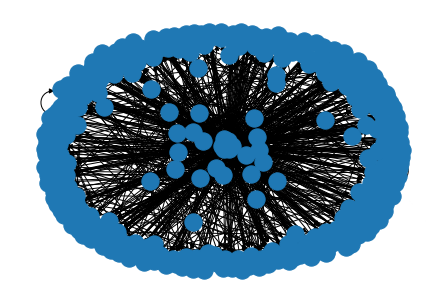

In [ ]:
nx.draw(G, pos = nx.spring_layout(G, k=1))

In [17]:
def custom_collate(batch):

  # batch is list of samples : batch = [dataset[0],dataset[1], and so on...]

  # lists to store titles and labels
  title1 = []
  title2 = []
  labels = []

  for sample in batch:

    title1.append(sample[0][0][1])
    title1.append(sample[0][1][1])
    title2.append(sample[1][0][1])
    title2.append(sample[1][1][1])
    labels.extend(sample[2])

  return {"title1": np.array(title1),"title2": np.array(title2), "labels":labels}

In [18]:
df.isnull().sum()/len(df)

Unnamed: 0    0.000000
Title         0.000000
Authors       0.041149
Year          0.000000
Venue         0.156545
Abstract      0.553710
Citations     0.800938
dtype: float64

In [19]:
class TitleBERT(nn.Module):

  def __init__(self):
    super().__init__()

    self.bertTitle = AutoModel.from_pretrained('allenai/scibert_scivocab_cased')
    self.linear = nn.Linear(768,1)

  def forward(self,inputs):

    outs = self.bertTitle(**inputs)
    outs = torch.mean(outs['last_hidden_state'],dim = 1)
    outs = self.linear(outs)
    outs = torch.sigmoid(outs)

    return outs

In [ ]:
class AbstractBERT(nn.Module):

  def __init__(self):
    super().__init__()

    self.bertAbstract = AutoModel.from_pretrained('allenai/scibert_scivocab_cased')
    self.linear = nn.Linear(768,1)

  def forward(self,inputs):

    outs = self.bertAbstract(**inputs)
    outs = torch.mean(outs['last_hidden_state'],dim = 1)
    outs = self.linear(outs)
    outs = torch.sigmoid(outs)

    return outs

In [ ]:
class VenueBERT(nn.Module):

  def __init__(self):
    super().__init__()

    self.bertVenue = AutoModel.from_pretrained('allenai/scibert_scivocab_cased')
    self.linear = nn.Linear(768,1)

  def forward(self,inputs):

    outs = self.bertAbstract(**inputs)
    outs = torch.mean(outs['last_hidden_state'],dim = 1)
    outs = self.linear(outs)
    outs = torch.sigmoid(outs)

    return outs

In [20]:
BATCH_SIZE = 256
trainloader = DataLoader(train_dataset, collate_fn = custom_collate, batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(test_dataset, collate_fn = custom_collate, batch_size = BATCH_SIZE, shuffle = True)

In [21]:
device = torch.device("cuda")

In [22]:
NUM_EPOCHS = 1

titlemodel = TitleBERT()
titlemodel.to(device)
criterion = nn.BCELoss()

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
for name,param in titlemodel.named_parameters():
    param.requires_grad = False

titlemodel.bertTitle.encoder.layer[11].attention.self.query.weight.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].attention.self.query.bias.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].attention.self.key.weight.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].attention.self.key.bias.requires_grad= True
titlemodel.bertTitle.encoder.layer[11].attention.self.value.weight.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].attention.self.value.bias.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].attention.output.dense.weight.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].attention.output.dense.bias.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].attention.output.LayerNorm.weight.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].attention.output.LayerNorm.bias.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].intermediate.dense.weight.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].intermediate.dense.bias.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].output.dense.weight.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].output.dense.bias.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].output.LayerNorm.weight.requires_grad = True
titlemodel.bertTitle.encoder.layer[11].output.LayerNorm.bias.requires_grad = True
titlemodel.bertTitle.pooler.dense.weight.requires_grad = True
titlemodel.bertTitle.pooler.dense.bias.requires_grad = True
titlemodel.linear.weight.requires_grad = True
titlemodel.linear.bias.requires_grad = True

for name,param in titlemodel.named_parameters():
  if (param.requires_grad == True):
    print(name)

bertTitle.encoder.layer.11.attention.self.query.weight
bertTitle.encoder.layer.11.attention.self.query.bias
bertTitle.encoder.layer.11.attention.self.key.weight
bertTitle.encoder.layer.11.attention.self.key.bias
bertTitle.encoder.layer.11.attention.self.value.weight
bertTitle.encoder.layer.11.attention.self.value.bias
bertTitle.encoder.layer.11.attention.output.dense.weight
bertTitle.encoder.layer.11.attention.output.dense.bias
bertTitle.encoder.layer.11.attention.output.LayerNorm.weight
bertTitle.encoder.layer.11.attention.output.LayerNorm.bias
bertTitle.encoder.layer.11.intermediate.dense.weight
bertTitle.encoder.layer.11.intermediate.dense.bias
bertTitle.encoder.layer.11.output.dense.weight
bertTitle.encoder.layer.11.output.dense.bias
bertTitle.encoder.layer.11.output.LayerNorm.weight
bertTitle.encoder.layer.11.output.LayerNorm.bias
bertTitle.pooler.dense.weight
bertTitle.pooler.dense.bias
linear.weight
linear.bias


In [24]:
def compute_accuracy(model, data_loader, device):
    
    model.eval()

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            print(f"{batch_idx} of {len(data_loader)}")

            ### Prepare data
            inputs = tokenizer(list(batch['title1']),list(batch['title2']),return_tensors='pt',
                    max_length = 32,
                    truncation = True,
                    padding = 'max_length')
            
            labels = torch.Tensor(batch['labels']).view(-1,1).to(device)
            
            outputs = model(inputs.to(device))

            predicted_labels = torch.round(outputs)

            num_examples += labels.size(0)

            correct_pred += (predicted_labels == labels).sum()

            print(correct_pred.float()/num_examples * 100)
    return correct_pred.float()/num_examples * 100

In [25]:
losses = []

from transformers import AdamW
optim = AdamW(titlemodel.parameters(), lr = 1e-3)

for epoch in range(NUM_EPOCHS):
    
    titlemodel.train()
    
    for batch_idx, batch in enumerate(trainloader):
        
      optim.zero_grad()

      inputs = tokenizer(list(batch['title1']),list(batch['title2']),return_tensors='pt',
                    max_length = 32,
                    truncation = True,
                    padding = 'max_length')
      output = titlemodel(inputs.to(device))
      
      loss = criterion(output.to(device),torch.tensor(np.array(batch['labels']).reshape(-1,1)).to(torch.float32).to(device))
      loss.backward()

      losses.append(loss.item())

      # if not batch_idx % 50:

      print(f"epoch number = {epoch}", f"batch {batch_idx}/{len(trainloader)}", f"loss = {round(loss.item(),2)}")

      optim.step()
            
    titlemodel.eval()
    with torch.set_grad_enabled(False):
        print(
              f'\ntest accuracy: '
              f'{compute_accuracy(titlemodel, testloader, device):.2f}%')

epoch number = 0 batch 0/1970 loss = 0.69
epoch number = 0 batch 1/1970 loss = 1.31
epoch number = 0 batch 2/1970 loss = 0.94
epoch number = 0 batch 3/1970 loss = 0.88
epoch number = 0 batch 4/1970 loss = 0.66
epoch number = 0 batch 5/1970 loss = 0.73
epoch number = 0 batch 6/1970 loss = 0.71
epoch number = 0 batch 7/1970 loss = 0.62
epoch number = 0 batch 8/1970 loss = 0.67
epoch number = 0 batch 9/1970 loss = 0.63
epoch number = 0 batch 10/1970 loss = 0.57
epoch number = 0 batch 11/1970 loss = 0.6
epoch number = 0 batch 12/1970 loss = 0.56
epoch number = 0 batch 13/1970 loss = 0.49
epoch number = 0 batch 14/1970 loss = 0.48
epoch number = 0 batch 15/1970 loss = 0.49
epoch number = 0 batch 16/1970 loss = 0.44
epoch number = 0 batch 17/1970 loss = 0.5
epoch number = 0 batch 18/1970 loss = 0.39
epoch number = 0 batch 19/1970 loss = 0.34
epoch number = 0 batch 20/1970 loss = 0.36
epoch number = 0 batch 21/1970 loss = 0.36
epoch number = 0 batch 22/1970 loss = 0.32
epoch number = 0 batch 

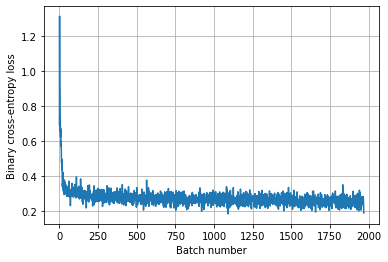

In [27]:
plt.plot(losses)
plt.ylabel("Binary cross-entropy loss")
plt.xlabel("Batch number")
plt.grid(True)
plt.savefig('titlebertloss.eps')
plt.show()

In [ ]:
def plot_loss_curve(loss, filename):

  plt.plot(loss)
  plt.ylabel("Binary cross-entropy loss")
  plt.xlabel("Batch number")
  plt.grid(True)
  plt.savefig(filename)
  plt.show()

plot_loss_curve(loss_list, 'drive/My Drive/Team USA/plots/venue_128.png')

In [29]:
compute_accuracy(titlemodel,testloader,device)

0 of 32
tensor(87.5000, device='cuda:0')
1 of 32
tensor(88.1836, device='cuda:0')
2 of 32
tensor(87.8906, device='cuda:0')
3 of 32
tensor(87.5977, device='cuda:0')
4 of 32
tensor(88.3203, device='cuda:0')
5 of 32
tensor(88.2487, device='cuda:0')
6 of 32
tensor(88.3371, device='cuda:0')
7 of 32


KeyboardInterrupt: ignored

In [ ]:
inputs = tokenizer(list(y['title1']),list(y['title2']),return_tensors='pt',
                    max_length = 32,
                    truncation = True,
                    padding = 'max_length')
output = titlemodel(inputs.to(device))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(torch.squeeze(torch.round(output)).detach().cpu().numpy(),y['labels'])

array([[461,  34],
       [ 51, 478]])

In [ ]:
compute_accuracy(titlemodel,testloader,device)

0 of 124
tensor(91.8945, device='cuda:0')
1 of 124
tensor(90.5762, device='cuda:0')
2 of 124
tensor(90.4622, device='cuda:0')
3 of 124


KeyboardInterrupt: ignored

In [ ]:
torch.save(titlemodel,'drive/My Drive/CMU/10-701/modelrun1.pth')

In [ ]:
titlebert = torch.load('drive/My Drive/CMU/10-701/modelrun1.pth')

# Abstracts

In [ ]:
## Read data in
df = pd.read_csv('drive/My Drive/CMU/10-701/dataset_corrected.csv')

In [ ]:
Abstracts = df[df['Abstract'].notnull()]

In [ ]:
# Create citation graph
Citations_Graph = Abstracts['Citations'].dropna().to_dict()

In [ ]:
indexes = set(Abstracts.index)

In [ ]:
# "explode" graph into tuples of x cites y
citations = [(key, int(value)) for key, values in Citations_Graph.items() for value in values.split(',')]

In [ ]:
citations_abstract = []
for i,vals in enumerate(citations):
  if (vals[0] in indexes and vals[1] in indexes):
    citations_abstract.append(vals)

In [ ]:
## Citations Graph : x cites y
import random

class Citations(Dataset):

  def __init__(self,citations,dataframe):
    super().__init__()
    
    self.citations = citations
    self.length = dataframe.shape[0]
    self.data = dataframe
    self.indexes = set(dataframe.index)

  def __len__(self):

    return len(self.citations)

  def __getitem__(self,index):

    X = []
    X.append(self.data.loc[self.citations[index][0],:].values)
    X.append(self.data.loc[self.citations[index][0],:].values)
   

    Y = []
    Y.append(self.data.loc[self.citations[index][1],:].values)
    Y.append(self.data.loc[random.sample(self.indexes,1)[0],:].values)


    labels = [1,0]
  
    return X,Y,labels

In [ ]:
train_abstract_citations = citations_abstract[:int(0.90*len(citations_abstract))]
test_abstract_citations = citations_abstract[int(0.90*len(citations_abstract))+1:]

In [ ]:
train_abstracts = Citations(train_abstract_citations,Abstracts)
test_abstracts = Citations(test_abstract_citations,Abstracts)

In [ ]:
def custom_collate_abstracts(batch):

  # batch is list of samples : batch = [dataset[0],dataset[1], and so on...]

  # lists to store titles and labels
  title1 = []
  title2 = []
  labels = []

  for sample in batch:

    title1.append(sample[0][0][-2])
    title1.append(sample[0][1][-2])
    title2.append(sample[1][0][-2])
    title2.append(sample[1][1][-2])
    labels.extend(sample[2])

  return {"title1": np.array(title1),"title2": np.array(title2), "labels":labels}

In [ ]:
BATCH_SIZE = 128
trainabstractsloader = DataLoader(train_abstracts, collate_fn = custom_collate_abstracts, batch_size = BATCH_SIZE, shuffle = True)
testabstractsloader = DataLoader(test_abstracts, collate_fn = custom_collate_abstracts, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
class AbstractBERT(nn.Module):

  def __init__(self):
    super().__init__()

    self.bertAbstract = AutoModel.from_pretrained('allenai/scibert_scivocab_cased')
    self.linear = nn.Linear(768,1)

  def forward(self,inputs):

    outs = self.bertAbstract(**inputs)
    outs = torch.mean(outs['last_hidden_state'],dim = 1)
    outs = self.linear(outs)
    outs = torch.sigmoid(outs)

    return outs

In [ ]:
NUM_EPOCHS = 1

device = torch.device("cuda")

abstractmodel = AbstractBERT()
criterion = nn.BCELoss()

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for name,param in abstractmodel.named_parameters():
    param.requires_grad = False

abstractmodel.bertAbstract.encoder.layer[11].attention.self.query.weight.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].attention.self.query.bias.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].attention.self.key.weight.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].attention.self.key.bias.requires_grad= True
abstractmodel.bertAbstract.encoder.layer[11].attention.self.value.weight.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].attention.self.value.bias.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].attention.output.dense.weight.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].attention.output.dense.bias.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].attention.output.LayerNorm.weight.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].attention.output.LayerNorm.bias.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].intermediate.dense.weight.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].intermediate.dense.bias.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].output.dense.weight.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].output.dense.bias.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].output.LayerNorm.weight.requires_grad = True
abstractmodel.bertAbstract.encoder.layer[11].output.LayerNorm.bias.requires_grad = True
abstractmodel.bertAbstract.pooler.dense.weight.requires_grad = True
abstractmodel.bertAbstract.pooler.dense.bias.requires_grad = True
abstractmodel.linear.weight.requires_grad = True
abstractmodel.linear.bias.requires_grad = True

for name,param in abstractmodel.named_parameters():
  if (param.requires_grad == True):
    print(name)

bertAbstract.encoder.layer.11.attention.self.query.weight
bertAbstract.encoder.layer.11.attention.self.query.bias
bertAbstract.encoder.layer.11.attention.self.key.weight
bertAbstract.encoder.layer.11.attention.self.key.bias
bertAbstract.encoder.layer.11.attention.self.value.weight
bertAbstract.encoder.layer.11.attention.self.value.bias
bertAbstract.encoder.layer.11.attention.output.dense.weight
bertAbstract.encoder.layer.11.attention.output.dense.bias
bertAbstract.encoder.layer.11.attention.output.LayerNorm.weight
bertAbstract.encoder.layer.11.attention.output.LayerNorm.bias
bertAbstract.encoder.layer.11.intermediate.dense.weight
bertAbstract.encoder.layer.11.intermediate.dense.bias
bertAbstract.encoder.layer.11.output.dense.weight
bertAbstract.encoder.layer.11.output.dense.bias
bertAbstract.encoder.layer.11.output.LayerNorm.weight
bertAbstract.encoder.layer.11.output.LayerNorm.bias
bertAbstract.pooler.dense.weight
bertAbstract.pooler.dense.bias
linear.weight
linear.bias


In [ ]:
def compute_accuracy(model, data_loader, device):
    
    model.eval()

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            print(f"{batch_idx} of {len(data_loader)}")

            ### Prepare data
            inputs = tokenizer(list(batch['title1']),list(batch['title2']),return_tensors='pt',
                    max_length = 32,
                    truncation = True,
                    padding = 'max_length')
            
            labels = torch.Tensor(batch['labels']).view(-1,1).to(device)
            
            outputs = model(inputs.to(device))

            predicted_labels = torch.round(outputs)

            num_examples += labels.size(0)

            correct_pred += (predicted_labels == labels).sum()

            print(correct_pred.float()/num_examples * 100)
    return correct_pred.float()/num_examples * 100

In [ ]:
from transformers import AdamW
optim = AdamW(abstractmodel.parameters(), lr = 1e-3)

for epoch in range(NUM_EPOCHS):
    
    abstractmodel.train()
    
    for batch_idx, batch in enumerate(trainabstractsloader):
        
      optim.zero_grad()

      inputs = tokenizer(list(batch['title1']),list(batch['title2']),return_tensors='pt',
                    max_length = 32,
                    truncation = True,
                    padding = 'max_length')
      output = abstractmodel(inputs)
      
      loss = criterion(output,torch.tensor(np.array(batch['labels']).reshape(-1,1)).to(torch.float32))
      loss.backward()

      # if not batch_idx % 50:

      print(f"epoch number = {epoch}", f"batch {batch_idx}/{len(trainabstractsloader)}", f"loss = {round(loss.item(),2)}")

      optim.step()
            
    abstractmodel.eval()
    with torch.set_grad_enabled(False):
        print(
              f'\ntest accuracy: '
              f'{compute_accuracy(titlemodel, testabstractsloader, device):.2f}%')

epoch number = 0 batch 0/1906 loss = 0.7
epoch number = 0 batch 1/1906 loss = 0.99
epoch number = 0 batch 2/1906 loss = 0.71
epoch number = 0 batch 3/1906 loss = 0.65
epoch number = 0 batch 4/1906 loss = 0.75
epoch number = 0 batch 5/1906 loss = 0.68
epoch number = 0 batch 6/1906 loss = 0.63
epoch number = 0 batch 7/1906 loss = 0.61
epoch number = 0 batch 8/1906 loss = 0.61
epoch number = 0 batch 9/1906 loss = 0.56
epoch number = 0 batch 10/1906 loss = 0.55
epoch number = 0 batch 11/1906 loss = 0.54
epoch number = 0 batch 12/1906 loss = 0.44
epoch number = 0 batch 13/1906 loss = 0.52
epoch number = 0 batch 14/1906 loss = 0.55
epoch number = 0 batch 15/1906 loss = 0.44
epoch number = 0 batch 16/1906 loss = 0.51
epoch number = 0 batch 17/1906 loss = 0.47
epoch number = 0 batch 18/1906 loss = 0.53
epoch number = 0 batch 19/1906 loss = 0.45
epoch number = 0 batch 20/1906 loss = 0.48
epoch number = 0 batch 21/1906 loss = 0.52
epoch number = 0 batch 22/1906 loss = 0.43
epoch number = 0 batch

KeyboardInterrupt: ignored

In [ ]:
compute_accuracy(abstractmodel,trainabstractsloader,'cpu')

0 of 1906
tensor(85.5469)
1 of 1906
tensor(84.1797)
2 of 1906
tensor(85.0260)
3 of 1906
tensor(84.7656)
4 of 1906
tensor(84.4531)
5 of 1906
tensor(85.0260)
6 of 1906
tensor(85.3795)
7 of 1906
tensor(85.0098)
8 of 1906
tensor(85.1128)
9 of 1906
tensor(84.8047)
10 of 1906
tensor(84.6236)
11 of 1906
tensor(84.7982)
12 of 1906
tensor(84.5252)
13 of 1906
tensor(84.4029)
14 of 1906
tensor(84.3750)
15 of 1906
tensor(84.2285)
16 of 1906
tensor(84.4439)
17 of 1906
tensor(84.5486)
18 of 1906
tensor(84.7451)
19 of 1906
tensor(84.7656)
20 of 1906
tensor(84.6912)
21 of 1906
tensor(84.6413)
22 of 1906
tensor(84.6128)
23 of 1906
tensor(84.6517)
24 of 1906
tensor(84.6875)
25 of 1906
tensor(84.7356)
26 of 1906
tensor(84.7656)
27 of 1906
tensor(84.6540)
28 of 1906
tensor(84.6579)
29 of 1906
tensor(84.7135)
30 of 1906
tensor(84.7908)
31 of 1906
tensor(84.6558)
32 of 1906
tensor(84.6117)
33 of 1906
tensor(84.5129)
34 of 1906
tensor(84.5201)
35 of 1906
tensor(84.5920)
36 of 1906
tensor(84.5545)
37 of 1906
